In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # put -1 to not use any

import sys
sys.path.append('/home/lumargot/hysterectomy-coach/src/py')


In [2]:

import json
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision.ops import nms
from sklearn.metrics import classification_report, confusion_matrix

from utils import *
from evaluation import *
from visualization import *
from nets.segmentation import FasterRCNN
from loaders.hyst_dataset import HystDataModuleSeg, BBXImageTestTransform, BBXImageTrainTransform, BBXImageEvalTransform


/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of Albumentations is available: '2.0.7' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [3]:
concats = [ 'Bipolar', 'Vessel Sealer', 'Robot Grasper Heat', 'Laparoscopic Scissors', 'Laparoscopic Suction', 'Robot Scissors', 'monopolarhook' ]
concats = [ 'Bipolar', 'Vessel Sealer', 'Scissors', 'Suction', 'Robot Scissors', 'monopolarhook' ]

def construct_class_mapping(df_labels, class_column, label_column):
    df_labels = df_labels.loc[df_labels[label_column] != 'Needle']
    df_labels.loc[ df_labels[label_column].isin(concats), label_column ] = 'Others'

    unique_classes = sorted(df_labels[label_column].unique())
    class_mapping = {value: idx+1 for idx, value in enumerate(unique_classes)}
    return class_mapping

def remove_labels(df, class_mapping, class_column, label_column):

    df = df.loc[df['to_drop'] == 0]
    
    df = df.loc[df[label_column] != 'Needle']
    df.loc[ df[label_column].isin(concats), label_column ] = 'Others'

    df[class_column] = df[label_column].map(class_mapping)

    print(f"{df[[label_column, class_column]].drop_duplicates()}")
    return df.reset_index()

In [4]:
df_test = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_test.csv')
df_train = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_train_test.csv')

img_column = 'img_path'
seg_column = 'seg_path'
class_column = 'simplified_class'
label_column = 'simplified_label'
mount_point = '/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/'


df_labels = pd.concat([df_train, df_val, df_test])
class_mapping = construct_class_mapping(df_labels, class_column, label_column)

df_test = remove_labels(df_test, class_mapping, class_column, label_column)
df_train = remove_labels(df_train, class_mapping, class_column, label_column)
df_val = remove_labels(df_val, class_mapping, class_column, label_column)


ttdata = HystDataModuleSeg( df_test, df_test, df_test, batch_size=1, num_workers=1, 
                            img_column=img_column,seg_column=seg_column, class_column=class_column, 
                            mount_point=mount_point,train_transform=BBXImageTrainTransform(),valid_transform=BBXImageEvalTransform(), 
                            test_transform=BBXImageTestTransform())

ttdata.setup()

test_dl = ttdata.test_dataloader()

     simplified_label  simplified_class
0             Grasper                 1
1       Needle Driver                 2
1117           Others                 3
   simplified_label  simplified_class
0           Grasper                 1
2     Needle Driver                 2
87           Others                 3
     simplified_label  simplified_class
0       Needle Driver                 2
1             Grasper                 1
1982           Others                 3


In [5]:
video_name = df_test['Video Name'].unique()
class_names = df_test['Instrument Name'].unique()
class_names = list(class_mapping.keys())

In [20]:
# data_dir = '/CMF/data/lumargot/hysterectomy/out/fasterRCNN/epoch=23-val_loss=0.10'
data_dir = '/CMF/data/lumargot/hysterectomy/out/fasterRCNN/epoch=9-val_loss=0.00'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/fasterRCNN/v2/epoch=29-val_loss=0.02'

ckpt = data_dir + '.ckpt'
model = FasterRCNN.load_from_checkpoint(ckpt)
    
model.eval()
model.cuda()

FasterRCNN(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momen

In [7]:
# with open(pred_file, 'rb') as f:
#   data = pickle.load(f)

## Functions

In [7]:
# def isinBox(box1, box2):
#   x11, y11, x12, y12 = box1
#   x21, y21, x22, y22 = box2

#   if (x11 < x21) and (x12 > x22):
#     if (y11 < y21) and (y12 > y22):
#       return True
#   return False
      

# def select_indices_to_keep(pred_labels, pred_boxes, pred_scores, iou_thr = 0.4):
#   """
#   Remove predictions if 1) box fully contained in another bigger box, 2) if iou > 0.7, 
#   3) if most of the box is contained in a bigger box and have the same labels (#TODO: maybe combined them instead)
#   """
#   n_pred = pred_labels.shape[0]
#   indices_to_remove = []
#   for j in range(n_pred):
#     # print(f"*** doing label {j} ***")
#     if j not in indices_to_remove :
#       for i in range(n_pred):
        
#         if i!=j:
#           # print(f"   for label {i}:")
#           if isinBox(pred_boxes[j], pred_boxes[i]):
#             # print(f'- box {i} removed ')
#             indices_to_remove.append(i)
#           iou, ratios = compute_bbx_iou(pred_boxes[j], pred_boxes[i], return_containment_ratio=True)

#           # print(f'- iou: {iou}')
#           # print(f'- ratio: {ratios}')

#           if (iou > iou_thr):
#             # print(pred_scores[i], pred_scores[j])
#             if pred_scores[i] > pred_scores[j]:
#               indices_to_remove.append(j)
#               # print(f"   removing {j}")
#             else :
#               indices_to_remove.append(i)
#               # print(f"    removing {i}")
#           if ratios[1] - ratios[0] >0.5:
#           # if (ratios[0] < 0.2) and (ratios[1] >0.5): 
#             if pred_labels[i] == pred_labels[j]:
#               # maybe for this one we should combine them ?
#               indices_to_remove.append(i)
#               # print(f"    {j} contains {i} -> removing {i}")


#           elif (ratios[0] >0.55) and (ratios[1]>0.55): # 2 overlaps that are very close
#             # print(f"- big overlap between boxes")
#             # print(pred_scores[i], pred_scores[j])

#             if pred_scores[i] > pred_scores[j]:
#               indices_to_remove.append(j)
#               # print(f"    {i} contains {j} -> removing {j}")

#             else :
#               indices_to_remove.append(i)
#               # print(f"    {j} contains {i} -> removing {i}")


#   indices_to_keep = np.linspace(0,n_pred-1, n_pred, dtype=int)
#   indices_to_remove = np.unique(indices_to_remove)
#   if len(indices_to_remove) > 0:
#     indices_to_keep = np.delete(indices_to_keep, indices_to_remove)
#   return indices_to_keep


In [8]:
# def remove_small_predictions(boxes, min_width=20, min_height=20):
#     widths = boxes[:, 2] - boxes[:, 0]
#     heights = boxes[:, 3] - boxes[:, 1]

#     keep_indices = (widths >= min_width) & (heights >= min_height)
#     return keep_indices

# def apply_indices_selection(input_dic, indices):
#   # print(len(input_dic['scores']))
#   output_dic = { k: v[indices] for k, v in input_dic.items()}
#   # print(len(output_dic['scores']))

#   return output_dic

In [8]:
def show_annotations(image, boxes, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=3,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            print(label, score)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()


In [9]:
def compute_color_dic(class_mapping):
  names, vals = list(class_mapping.keys()), list(class_mapping.values())
  brightness = 1.0 
  hsv = [(i / len(names), 1, brightness) for i in range(len(names))]
  colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
  
  dic_color_names = {cls : col for cls,col in zip(names, colors)}
  dic_color_vals = {cls : col for cls,col in zip(vals, colors)}
  
  return dic_color_names, dic_color_vals
  
def isinBox(box1, box2):
  x11, y11, x12, y12 = box1
  x21, y21, x22, y22 = box2

  if (x11 < x21) and (x12 > x22):
    if (y11 < y21) and (y12 > y22):
      return True
  return False
      
def remove_small_predictions(boxes, min_width=20, min_height=20):
    widths = boxes[:, 2] - boxes[:, 0]
    heights = boxes[:, 3] - boxes[:, 1]

    keep_indices = (widths >= min_width) & (heights >= min_height)
    return keep_indices
def apply_indices_selection(input_dic, indices):
  output_dic = { k: v[indices] for k, v in input_dic.items()}
  return output_dic

def select_indices_to_keep(pred_labels, pred_boxes, pred_scores, iou_thr = 0.4):
  """
  Remove predictions if 1) box fully contained in another bigger box, 2) if iou > 0.7, 
  3) if most of the box is contained in a bigger box and have the same labels (#TODO: maybe combined them instead)
  """
  n_pred = pred_labels.shape[0]
  indices_to_remove = []
  for j in range(n_pred):
    if j not in indices_to_remove :
      for i in range(n_pred):
        if i!=j:
          if isinBox(pred_boxes[j], pred_boxes[i]):
            indices_to_remove.append(i)
          iou, ratios = compute_bbx_iou(pred_boxes[j], pred_boxes[i], return_containment_ratio=True)


          if (iou > iou_thr):
            if pred_scores[i] > pred_scores[j]:
              indices_to_remove.append(j)
            else :
              indices_to_remove.append(i)
          if ratios[1] - ratios[0] >0.5:
            if pred_labels[i] == pred_labels[j]:
              indices_to_remove.append(i)

          elif (ratios[0] >0.55) and (ratios[1]>0.55): # 2 overlaps that are very close
            if pred_scores[i] > pred_scores[j]:
              indices_to_remove.append(j)
            else :
              indices_to_remove.append(i)

  indices_to_keep = np.linspace(0,n_pred-1, n_pred, dtype=int)
  indices_to_remove = np.unique(indices_to_remove)
  if len(indices_to_remove) > 0:
    indices_to_keep = np.delete(indices_to_keep, indices_to_remove)
  return indices_to_keep


## Evaluation

In [10]:
# # ~4min
# num_preds, num_fps, num_fns,num_low_nms = 0, 0, 0, 0
# num_small_pred, num_low_confidence, num_drop_indices = 0, 0, 0
# l_ious, l_distances = [], []
# gt, pred = [], []
# l_dice = []

# all_gt = []
# all_pred = []

# for out_img in data:
#   pred_boxes = out_img['pred_boxes']
#   pred_scores = out_img['pred_scores']
#   pred_labels = out_img['pred_labels']

#   gt_boxes = out_img['gt_boxes']
#   gt_labels = out_img['gt_labels']

#   pred_dic = {'boxes':pred_boxes, 'scores':pred_scores, 'labels':pred_labels}
#   gt_dic = {'boxes':gt_boxes, 'labels':gt_labels}

  
#   SCORE_THR = 0.5
#   if (pred_dic['scores'] >= SCORE_THR).any():
#     # also do it for ground truth
#     keep = pred_dic['scores'] >= SCORE_THR
#     num_low_confidence = pred_dic['boxes'].shape[0] - len(keep)
#     pred_dic=apply_indices_selection(pred_dic, keep)

#     nms_indices = nms(torch.tensor(pred_dic['boxes']), torch.tensor(pred_dic['scores']),0.3)
#     num_low_nms += (pred_dic['boxes'].shape[0] - len(nms_indices))
#     pred_dic=apply_indices_selection(pred_dic, nms_indices)

#     if len(pred_dic['boxes'].shape) == 1: # 1 element
#       pred_dic = { k: np.expand_dims(v, axis=0) for k, v in pred_dic.items()}

#     indices_keep = select_indices_to_keep(pred_dic['labels'], pred_dic['boxes'], pred_dic['scores'])
#     num_drop_indices += (pred_dic['boxes'].shape[0] - len(indices_keep))
#     pred_dic=apply_indices_selection(pred_dic, indices_keep)

#   else:
#     num_fns += len(gt_boxes)

#   n_p, n_fp, n_fn, i, gt_ix, pred_idx = evaluate_with_fp_fn(gt_dic['boxes'], pred_dic['boxes'])

#   gt.append(torch.tensor(gt_labels[gt_ix]))
#   pred.append(torch.tensor(pred_labels[pred_idx]))

#   num_preds += n_p
#   num_fps += n_fp
#   num_fns += n_fn
#   l_ious.append(torch.tensor(i).reshape(-1))

# ious = torch.cat(l_ious, dim=0)
# pred = torch.cat(pred)
# gt = torch.cat(gt)

# total_detections = num_preds + num_fns + num_fps
# out_dict = {'Matched Prediction': num_preds,
#             'Ratio match prediction': 100*num_preds/total_detections, 
#             'False Positives':num_fps,
#             'Ratio FP': 100*num_fps/total_detections, 
#             'False Negatives':num_fns,
#             'Ration FN': 100*num_fns/total_detections, 
#             'Mean IoU': ious.mean().item(),
#             }
# print(json.dumps(out_dict, indent=2))

In [11]:
# all_gt = []
# all_pred = []

# for out_img in data:
#   pred_boxes = out_img['pred_boxes']
#   pred_scores = out_img['pred_scores']
#   pred_labels = out_img['pred_labels']

#   gt_boxes = out_img['gt_boxes']
#   gt_labels = out_img['gt_labels']

#   pred_dic = {'boxes':pred_boxes, 'scores':pred_scores, 'labels':pred_labels}
#   gt_dic = {'boxes':gt_boxes, 'labels':gt_labels}
  
#   SCORE_THR = 0.5
#   if (pred_scores >=SCORE_THR).any():

#       keep = pred_scores >= SCORE_THR
#       pred_dic=apply_indices_selection(pred_dic, keep)

#       pred_dic = { k: torch.tensor(v) for k, v in pred_dic.items()}

#       nms_indices = nms(pred_dic['boxes'], pred_dic['scores'],0.3)
#       pred_dic=apply_indices_selection(pred_dic, nms_indices)

#       indices_keep = select_indices_to_keep(pred_dic['labels'], pred_dic['boxes'], pred_dic['scores'])
#       pred_dic=apply_indices_selection(pred_dic, indices_keep)
#   else:
#       pred_dic = {'boxes':np.array([]), 'scores':np.array([]), 'labels':np.array([])}
      
#   all_gt.append(gt_dic)
#   all_pred.append(pred_dic)

In [12]:
video_names = df_test['Video Name'].unique()

In [21]:
# for video_idx in range(len(video_name)):

all_gt = []
all_pred = []
cls_names = np.insert(np.array(class_names), 0, 'Background')
color_names, color_vals = compute_color_dic(class_mapping)
show = False
SCORE_THR = 0.5

# for video_idx in range(1):
for video_idx in range(len(video_names)):

    df_vid = df_test.loc[ df_test['Video Name'] == video_names[video_idx]]



    ttdata = HystDataModuleSeg( df_vid, df_vid, df_vid, batch_size=10, num_workers=1, 
                                img_column=img_column,seg_column=seg_column, class_column=class_column, 
                                mount_point=mount_point,train_transform=BBXImageTrainTransform(),valid_transform=BBXImageEvalTransform(), 
                                test_transform=BBXImageTestTransform())

    ttdata.setup()
    test_dl = ttdata.test_dataloader()
    test_ds = ttdata.test_ds

    with torch.no_grad():
        for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)): 
            if idx > 0:
                try:
        
                    imgs = []
                    img, batch = batch

                    imgs.append(img)
                    imgs = torch.cat(imgs)

                    outputs = model.forward(imgs.cuda(), mode='test')
                    img_np = 255*imgs[0].permute(1,2,0).numpy()
                    
                    pred_boxes = outputs[0]['boxes'].cpu().detach()
                    pred_labels = outputs[0]['labels'].cpu().detach()
                    pred_scores = outputs[0]['scores'].cpu().detach()

                    gt_boxes = batch[0]['boxes'].numpy()
                    gt_labels = batch[0]['labels'].cpu().detach().numpy()

                    pred_dic = {'boxes':pred_boxes, 'scores':pred_scores, 'labels':pred_labels}
                    gt_dic = {'boxes':gt_boxes, 'labels':gt_labels}


                    if (pred_scores >=SCORE_THR).any():
                        
                        keep = pred_scores >= SCORE_THR
                        pred_dic=apply_indices_selection(pred_dic, keep)

                        nms_indices = nms(pred_dic['boxes'], pred_dic['scores'],0.3)
                        pred_dic_filtered=apply_indices_selection(pred_dic, nms_indices)

                        indices_keep = select_indices_to_keep(pred_dic_filtered['labels'], pred_dic_filtered['boxes'], pred_dic_filtered['scores'])
                        pred_dic_filtered=apply_indices_selection(pred_dic_filtered, indices_keep)

                        if show :

                            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,  figsize=(30, 10))
                            gt_colors = [ color_vals[val] for val in gt_labels]
                            show_annotations(ax=ax1, image=img_np, boxes=gt_boxes[:, [1, 0, 3, 2]],
                                            class_ids=gt_labels, class_names=cls_names, colors=gt_colors, show_bbox=True,title='Ground Truth',figsize = (10,10))
                            
                            pred_colors = [ color_vals[val] for val in pred_dic['labels'].numpy()]
                            show_annotations(ax=ax2, image=img_np, boxes=pred_dic['boxes'][:, [1, 0, 3, 2]].numpy(),
                                            class_ids=pred_dic['labels'].numpy(), class_names=cls_names, colors=pred_colors, scores=pred_dic['scores'].numpy(),
                                            show_bbox=True,title='Raw output',figsize = (10,10))
                            
                            pred_colors_filtered = [ color_vals[val] for val in pred_dic['labels'].numpy()]
                            show_annotations(ax=ax3, image=img_np, boxes=pred_dic_filtered['boxes'][:, [1, 0, 3, 2]].numpy(),
                                            class_ids=pred_dic_filtered['labels'].numpy(), class_names=cls_names,  colors=pred_colors_filtered,
                                            scores=pred_dic_filtered['scores'].numpy(), show_bbox=True,title='Filtering',figsize = (10,10),)

                            plt.show()
                            plt.close()

                    else:
                        pred_dic_filtered = {'boxes':np.array([]), 'scores':np.array([]), 'labels':np.array([])}
                        pred_dic = {'boxes':np.array([]), 'scores':np.array([]), 'labels':np.array([])}
                        
                    all_gt.append(gt_dic)
                    all_pred.append(pred_dic_filtered)

                except:
                    pass

            # if idx == 10:
            #     break

100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

In [ ]:
# def compute_iou_masks(pred_masks, gt_masks):
#     """Computes IoU between binary masks (pred vs gt)"""
#     ious = torch.zeros((len(pred_masks), len(gt_masks)))
#     for i, pm in enumerate(pred_masks):
#         for j, gm in enumerate(gt_masks):
#             intersection = torch.logical_and(pm, gm).sum().float()
#             union = torch.logical_or(pm, gm).sum().float()
#             ious[i, j] = intersection / union if union > 0 else 0.0
#     return ious

# def evaluate_faster_rcnn(ground_truth, predictions, classes, iou_threshold=0.5):
#     y_true = []
#     y_pred = []
#     total_fp = 0
#     total_fn = 0
#     total_tp = 0


#     stats = defaultdict(list)
#     for gt, pred in zip(ground_truth, predictions):
#         gt_boxes = torch.tensor(gt['boxes'])
#         gt_labels = torch.tensor(gt['labels'])

#         pred_boxes = torch.tensor(pred['boxes'])
#         pred_labels = torch.tensor(pred['labels'])
#         pred_scores = torch.tensor(pred['scores'])

#         if len(pred_boxes) == 0:
#             # All ground truths are missed (false negatives)
#             total_fn += len(gt_boxes)
#             continue
#         if len(gt_boxes) == 0:
#             # All predictions are false positives
#             total_fp += len(pred_boxes)
#             continue

#         box_ious = box_iou(pred_boxes, gt_boxes)
#         matched_gt = set()
#         matched_pred = set()

#         for i, score in enumerate(pred_scores):
#             max_box_iou, box_match = torch.max(box_ious[i], dim=0)
#             matched = (max_box_iou > iou_threshold) and  (pred_labels[i] == gt_labels[box_match])

#             stats['scores'].append(score.item())
#             stats['box_iou'].append(max_box_iou.item())
#             stats['matched'].append(matched)

#             if max_box_iou > iou_threshold  and box_match.item() not in matched_gt:
#                 y_true.append(gt_labels[box_match].item())
#                 y_pred.append(pred_labels[i].item())
#                 matched_gt.add(box_match.item())
#                 matched_pred.add(i)
#                 total_tp += 1
#         total_fn += len(gt_boxes) - len(matched_gt)
#         total_fp += len(pred_boxes) - len(matched_pred)


#     precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
#     recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
#     mean_box_iou = np.mean(stats['box_iou']) if stats['box_iou'] else 0.0

#     # Compute AP per class (macro average)
#     ap_per_class = {}
#     for cls in classes:
#         cls_id = classes.index(cls) +1
#         y_true_bin = [1 if y == cls_id else 0 for y in y_true]
#         y_pred_bin = [1 if y == cls_id else 0 for y in y_pred]
#         if any(y_true_bin):  # Only compute AP if this class is present in GT
#             ap = average_precision_score(y_true_bin, y_pred_bin)
#         else:
#             ap = float('nan')  # or 0.0
#         ap_per_class[cls] = ap
#     valid_aps = [ap for ap in ap_per_class.values() if not np.isnan(ap)]
#     mean_ap = np.mean(valid_aps) if valid_aps else 0.0

#     return {
#         f'precision@IoU>{iou_threshold}': precision,
#         'recall': recall,
#         'f1_score': f1,
#         'mean_box_iou': mean_box_iou,
#         'false_positives': total_fp,
#         'false_negatives': total_fn,
#         'true_positives': total_tp,
#         'average_precision_per_class': ap_per_class,
#         'mean_average_precision': mean_ap,
#         'num_predictions': len(stats['scores']),
#         'labels': classes}, y_true, y_pred

In [22]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.5081479346252488


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


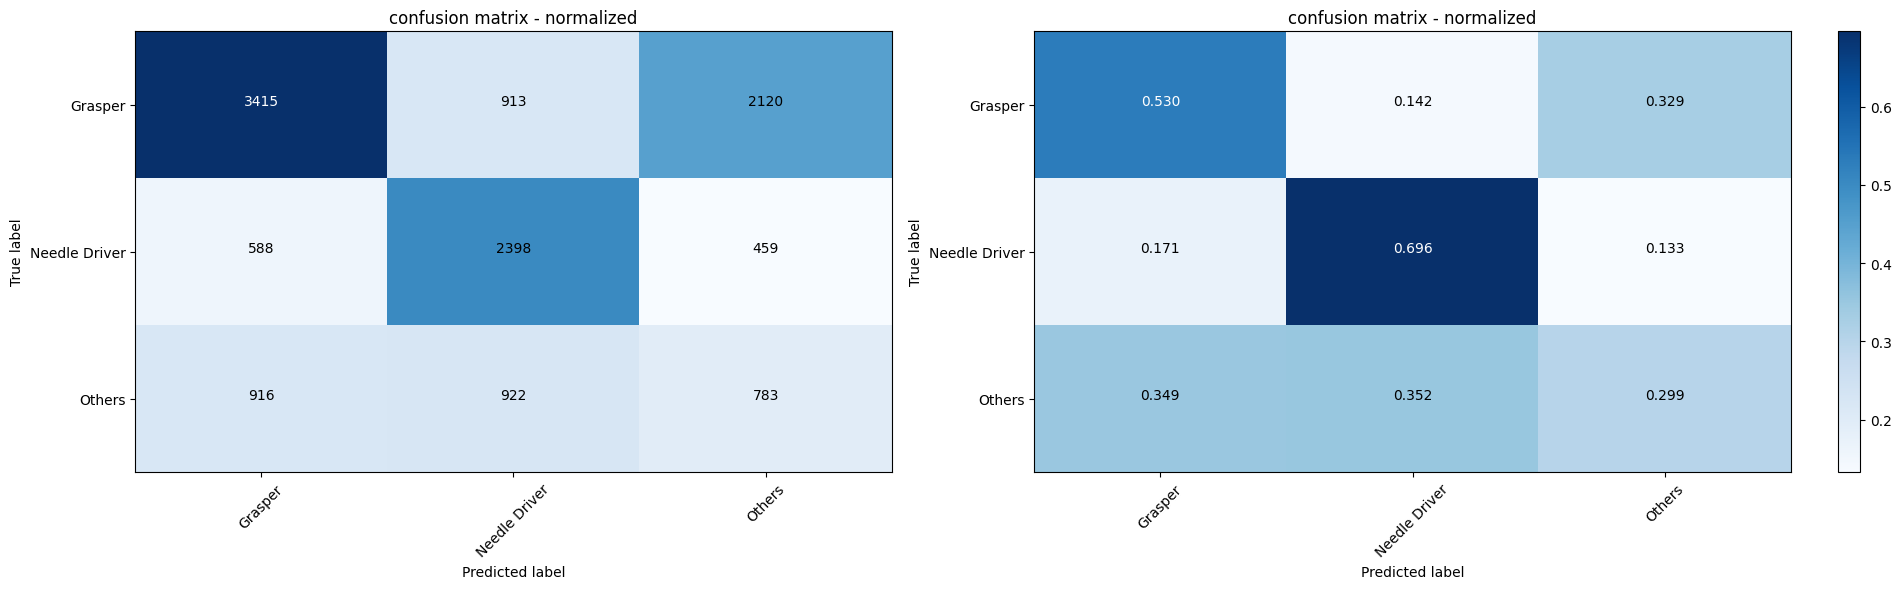

In [ ]:
# mapping2 = {v: k for k, v in class_mapping.items()}
# out, y_true, y_pred = evaluate_mask_rcnn(all_gt, all_pred, class_names, iou_threshold=0.25)

# names = np.unique( np.concatenate([ y_true, y_pred]) )
# class_names_vid = [ mapping2[k] for k in names]

# cnf = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(20,6))
# plt.subplot(121)
# plot_confusion_matrix(cnf, classes=class_names_vid, normalize=False, title='confusion matrix - normalized')
# plt.subplot(122)
# plot_confusion_matrix(cnf, classes=class_names_vid, normalize=True, title='confusion matrix - normalized')
# plt.show()
# plt.close()

In [23]:
df_pred, out_dict = evaluate_faster_rcnn(all_gt, all_pred, class_names, iou_threshold=0.5)

df_pred.to_csv(os.path.join(data_dir, 'prediction.csv'))

print(json.dumps(out_dict, indent=2))
filename = os.path.join(data_dir, 'output_stats.json')
with open(filename, 'w') as file:
    json.dump(out_dict, file, indent=2)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{
  "precision@IoU>0.5": 0.46031042128603106,
  "recall": 0.3667844522968198,
  "f1_score": 0.40825958702064896,
  "mean_box_iou": 0.4093513601444165,
  "false_positives": 1217,
  "false_negatives": 1792,
  "true_positives": 1038,
  "average_precision_per_class": {
    "Grasper": 0.650182968481098,
    "Needle Driver": 0.442253347166642,
    "Others": 0.20831963024703115
  },
  "mean_average_precision": 0.4335853152982571,
  "num_predictions": 2255,
  "labels": [
    "Grasper",
    "Needle Driver",
    "Others"
  ],
  "pr_curve_data": {
    "scores": [
      0.7368634343147278,
      0.5526774525642395,
      0.5545938014984131,
      0.600959062576294,
      0.5896215438842773,
      0.6192232966423035,
      0.5812641382217407,
      0.6454419493675232,
      0.5685547590255737,
      0.6598789095878601,
      0.614288866519928,
      0.6643304228782654,
      0.572364866733551,
      0.679538369178772,
      0.5270978212356567,
      0.6904646158218384,
      0.6055989265441895,
   

In [24]:
# class_names = ['Background', 'Laparoscopic Grasper', 'Laparoscopic Needle Driver', 'Needle', 'Robot Needle Driver', 'Robot Grasper','Other']
report = classification_report(df_pred['gt'], df_pred['pred'], output_dict=True)
print(report)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv(os.path.join(data_dir, 'classification_report.csv'))

{'1': {'precision': 0.7331730769230769, 'recall': 0.5267702936096719, 'f1-score': 0.6130653266331658, 'support': 579}, '2': {'precision': 0.5370370370370371, 'recall': 0.6692307692307692, 'f1-score': 0.5958904109589042, 'support': 260}, '3': {'precision': 0.23825503355704697, 'recall': 0.35678391959798994, 'f1-score': 0.2857142857142857, 'support': 199}, 'accuracy': 0.5298651252408478, 'macro avg': {'precision': 0.5028217158390537, 'recall': 0.5175949941461436, 'f1-score': 0.4982233411021186, 'support': 1038}, 'weighted avg': {'precision': 0.5891614574623734, 'recall': 0.5298651252408478, 'f1-score': 0.5460052734364749, 'support': 1038}}


Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.5175949941461436


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


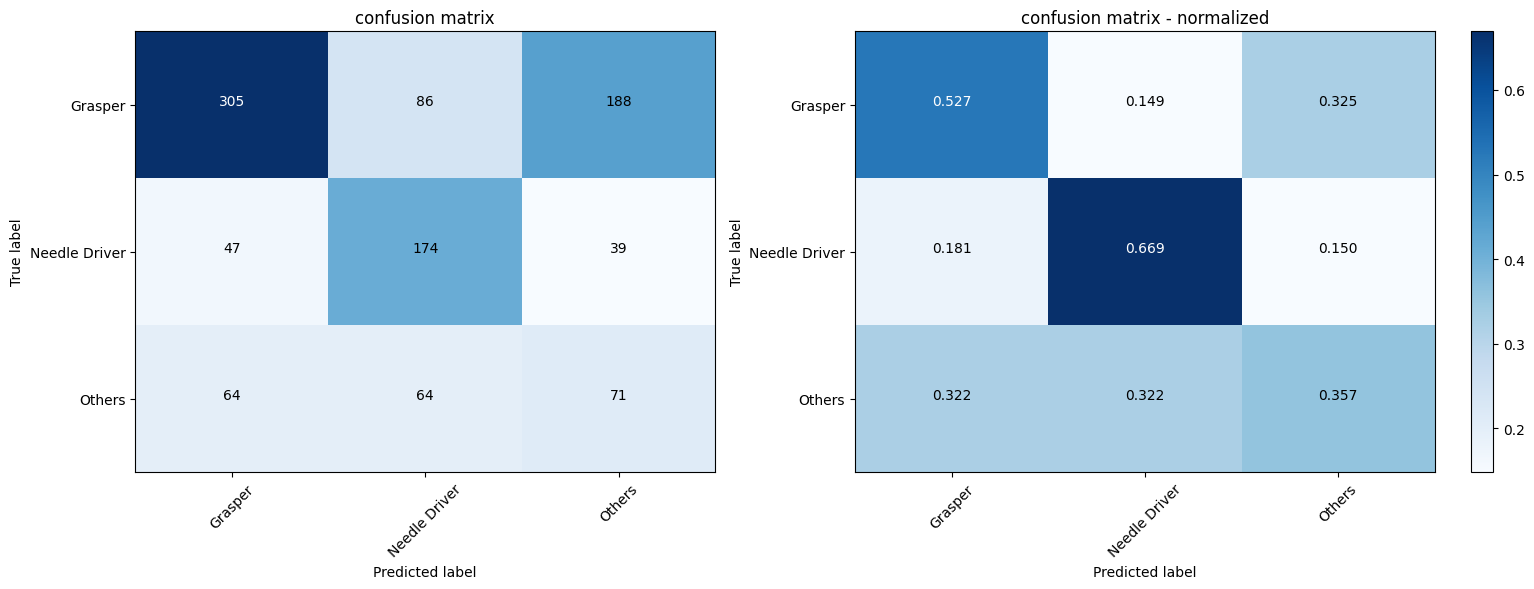

In [25]:
cnf_matrix = confusion_matrix(df_pred['gt'], df_pred['pred'])
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')
plt.savefig(os.path.join(data_dir, 'confusion_matrix.png'))